# **C.O.L.L.A.B.**
<hr style="border:2px solid black">

## Goal: 
* Create an interactive dashbard to assist families with moving
* Create and implement additional features like violent crime rate, commute time, and internet accessibility
<hr style="border:2px solid black">

# Imports

In [2]:
import pandas as pd
import numpy as np
from wrangle_2 import wrangle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import sklearn
import random
from itertools import product
import explore as ex
random.seed(42)
np.random.seed(42)
from scipy import stats

<hr style="border:2px solid black">

# **Acquire**
Plan --> **Acquire** --> Prepare --> Explore --> Model --> Deliver

* Economic Policy Institute Family Budget Calculator (Cost estimates for by family size and MSA)
* US Census Bureau - (Commute times, Household Income by Gender and Family Composition)
* Federal Bureau of Investigation (Crime Rates)

<hr style="border:2px solid black">

# **Prepare**

**Prepare Actions:**
* Merge census dataframes family_income and family_count on MSA
* To better estimate family income based on family composition, use the estimates of family count by family type(Married, Single Male with kids, Single Male without kids, Single Female with kids, Single Female without kids) and the estimates of income by family type. e.g. (female_with_kids (income) * female_with_kids (count) + (male_with_kids (income) * male_with_kids (count)))/(total_count)
* Adjust for inflation 2020 to 2022
* Merge census dataframe (family) on to the cost_of_living dataframe (col) on MSA.
* Estimate an average commute time for each MSA by multiplying the count of commuters by the midpoint of the range and dividing by the total number of commuters.
* Transform the values of the msa column in epi, census, and fbi datasets to standard format for merging.
* Merge epi, census, and fbi datasets.

In [3]:
cost, epi_census, fbi, intern, commute = wrangle()

<hr style="border:2px solid black">

# **Clustering**
Plan --> Acquire --> Prepare --> Explore --> **Model** --> Deliver


In [4]:
cost.columns

Index(['msa', 'parents', 'children', 'housing', 'food', 'transportation',
       'healthcare', 'other', 'childcare', 'taxes', 'total',
       'median_family_income', 'affordability_ratio', 'total_commute',
       'under_5', '5-9', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39',
       '40-44', '45-59', '60-89', '90+', 'est_commute', 'violent_crime',
       'murder_and_nonnegligent_manslaughter', 'rape', 'robbery',
       'aggravated_assault', 'property_crime', 'burglary', 'larceny_theft',
       'motor_vehicle_theft', 'homes_with_computer', 'homes_with_internet',
       'in_preschool', 'in_kindergarten', 'in_junior_high', 'in_high_school',
       'in_college_plus', 'less_than_high_school', 'high_school_to_associates',
       'bachelors_plus'],
      dtype='object')

In [5]:
def cluster_dataframe(df, features, n_clusters=3, scaler=MinMaxScaler(), cluster_algo=KMeans(random_state=42), plot=False):
    # Scale the specified columns
    def scale_columns(df, scaler=MinMaxScaler()):
        scaled_columns = df[df.columns.difference(['msa'])]
        scaled_values = scaler.fit_transform(scaled_columns)
        for col, values in zip(scaled_columns.columns, scaled_values.T):
            df[f'{col}_scaled'] = values
        return df

    df = scale_columns(df, scaler)
    
    # Select the features to cluster
    X = df[[f'{feature}_scaled' for feature in features]]
    
    # Fit the clustering algorithm and predict the clusters
    cluster_algo.set_params(n_clusters=n_clusters)
    clusters = cluster_algo.fit_predict(X)
    
    # Add the clusters to the original dataframe
    df['cluster'] = clusters
    
    if plot:
        # Plot the clusters on 'affordability', 'violent_crime', and 'est_commute'
        pairplot = sns.pairplot(data=df, vars=['affordability_ratio','violent_crime','est_commute', 'property_crime'], hue='cluster', palette='RdYlGn')
        pairplot.fig.suptitle('Clusters', y=1.02)  # y=1.02 raises the title slightly
        plt.show()

In [6]:
features = ['est_commute', 'violent_crime', 'property_crime']
cluster_dataframe(cost, features, 4, scaler=MinMaxScaler(), cluster_algo=KMeans(), plot=False)

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [7]:
# map clusters
cost['cluster'] = cost['cluster'].map({0: 'Moderate_Crime_Low_Commute', 1: 'Low_Crime_Low_Commute', 2: 'Moderate_Crime_High_Commute', 3: 'High_Crime_Moderate_Commute'})

In [8]:
def split_dataframe_by_family_type(cost):
    # create a dictionary to map the number of parents and children to a string
    mapping = {(1, i): f'single_{i}_child' for i in range(5)}
    mapping.update({(2, i): f'married_{i}_child' for i in range(5)})
    # create a new column in the cost dataframe that maps the number of parents and children to a string
    cost['family_type'] = cost.apply(lambda row: mapping[(row['parents'], row['children'])], axis=1)
    # split the cost dataframe into ten dataframes based on the family_type column and drop the family_type column
    dataframes = {family_type: df.drop(columns='family_type') for family_type, df in cost.groupby('family_type')}
    family_types = ['single_0_child', 'single_1_child', 'single_2_child', 'single_3_child', 'single_4_child',
                    'married_0_child', 'married_1_child', 'married_2_child', 'married_3_child', 'married_4_child']
    # create a variable for each dataframe
    for family_type in family_types:
        globals()[family_type] = dataframes[family_type]
    # create a list of dataframes
    globals()['df_list'] = [globals()[family_type] for family_type in family_types]
    # create a list of dataframe names
    globals()['df_names'] = [family_type for family_type in family_types]
    return

In [9]:
split_dataframe_by_family_type(cost)

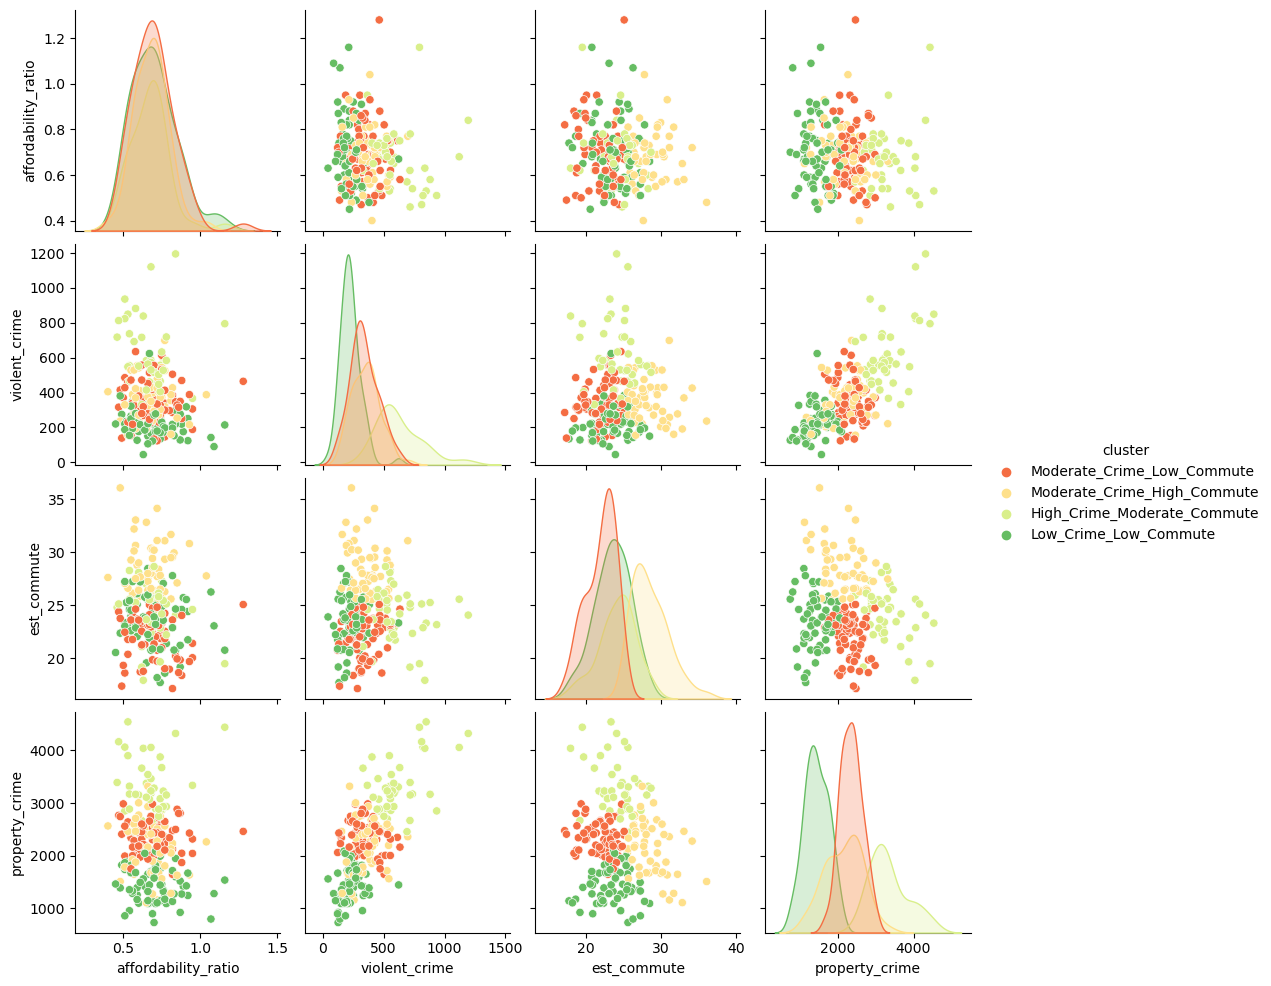

In [10]:
sns.pairplot(data=single_1_child, vars=['affordability_ratio','violent_crime','est_commute', 'property_crime'], hue='cluster', palette='RdYlGn')

<hr style="border:2px solid black">

# **Explore**
Plan --> Acquire --> Prepare --> **Explore** --> Model --> Deliver

> ### <u>Does the Low_Crime_Low_Commute cluster have a significantly lower mean violent_crime rate than the population?</u>

<div style="background-color: #A9CCE3; box-shadow: 0 0 0 1px black; padding: 5px;">

**I will now use a 1 sample, 1 tail, T-test to investigate whether the mean violent_crime rate for the Low_Crime_Low_Commute cluster is significantly less than the mean violent_crime rate for the population.**

* I will use a confidence interval of 95% 
* The resulting alpha is .05<br>

**H0: Mean of violent_crime of Low_Crime_Low_Commute => Mean of violent_crime of all MSAs.**<br>
**Ha: Mean of violent_crime of Low_Crime_Low_Commute < Mean of violent_crime of all MSAs.**
</div>

In [11]:
alpha = 0.5
# cluster sample
low_crime = cost[cost['cluster'] == 'Low_Crime_Low_Commute'].violent_crime
# population mean
pop_mean = cost.violent_crime.mean()

t, p = stats.ttest_1samp(low_crime, pop_mean)

print(t, p/2, alpha)

if p/2 > alpha:
    print("We fail to reject the null hypothesis.")
elif t > 0:
    print("We fail to reject null hypothesis.")
else:
    print("We reject the null hypothesis.")

-41.48516198194628 1.9448914745976395e-187 0.5
We reject the null hypothesis.


> ### <u>Does the Moderate_Crime_Low_Commute cluster have a significantly lower mean est_commute than the population?</u>

<div style="background-color: #A9CCE3; box-shadow: 0 0 0 1px black; padding: 5px;">

**I will now use a 1 sample, 1 tail, T-test to investigate whether the mean est_commute rate for the Moderate_Crime_Low_Commute cluster is significantly less than the mean est_commute rate for the population.**

* I will use a confidence interval of 95% 
* The resulting alpha is .05<br>

**H0: Mean of est_commute of Moderate_Crime_Low_Commute => Mean of est_commute of all MSAs.**<br>
**Ha: Mean of est_commute of Moderate_Crime_Low_Commute < Mean of est_commute of all MSAs.**
</div>

In [12]:
alpha = 0.5
# cluster sample
low_commute = cost[cost['cluster'] == 'Moderate_Crime_Low_Commute'].est_commute
# population mean
pop_mean = cost.est_commute.mean()

t, p = stats.ttest_1samp(low_commute, pop_mean)

print(t, p/2, alpha)

if p/2 > alpha:
    print("We fail to reject the null hypothesis.")
elif t > 0:
    print("We fail to reject null hypothesis.")
else:
    print("We reject the null hypothesis.")

-31.11314991501109 4.462433233889858e-133 0.5
We reject the null hypothesis.


> ### <u>Does the High_Crime_Moderate_Commute cluster have a significantly higher mean violent_crime rate than the population??</u>

<div style="background-color: #A9CCE3; box-shadow: 0 0 0 1px black; padding: 5px;">

**I will now use a 1 sample, 1 tail, T-test to investigate whether the mean violent_crime rate for the High_Crime_Moderate_Commute cluster is significantly higher than the mean violent_crime rate for the population.**

* I will use a confidence interval of 95% 
* The resulting alpha is .05<br>

**H0: Mean of violent_crime of High_Crime_Moderate_Commute <= Mean of violent_crime of all MSAs.**<br>
**Ha: Mean of violent_crime of High_Crime_Moderate_Commute > Mean of violent_crime of all MSAs.**
</div>

In [13]:
alpha = 0.5
# cluster sample
high_crime = cost[cost['cluster'] == 'High_Crime_Moderate_Commute'].violent_crime
# population mean
pop_mean = cost.violent_crime.mean()

t, p = stats.ttest_1samp(high_crime, pop_mean)

print(t, p/2, alpha)

if p/2 > alpha:
    print("We fail to reject the null hypothesis.")
elif t < 0:
    print("We fail to reject null hypothesis.")
else:
    print("We reject the null hypothesis.")

28.949511976492715 2.5989161914687345e-102 0.5
We reject the null hypothesis.


> ### <u>Does the Moderate_Crime_High_Commute cluster have a significantly higher mean est_commute than the population?</u>

<div style="background-color: #A9CCE3; box-shadow: 0 0 0 1px black; padding: 5px;">

**I will now use a 1 sample, 1 tail, T-test to investigate whether the mean est_commute rate for the Moderate_Crime_High_Commute cluster is significantly higher than the mean est_commute rate for the population.**

* I will use a confidence interval of 95% 
* The resulting alpha is .05<br>

**H0: Mean of est_commute of Moderate_Crime_High_Commute <= Mean of est_commute of all MSAs.**<br>
**Ha: Mean of est_commute of Moderate_Crime_High_Commute > Mean of est_commute of all MSAs.**
</div>

In [15]:
alpha = 0.5
# cluster sample
high_commute = cost[cost['cluster'] == 'Moderate_Crime_High_Commute'].est_commute
# population mean
pop_mean = cost.est_commute.mean()

t, p = stats.ttest_1samp(high_commute, pop_mean)

print(t, p/2, alpha)

if p/2 > alpha:
    print("We fail to reject the null hypothesis.")
elif t < 0:
    print("We fail to reject null hypothesis.")
else:
    print("We reject the null hypothesis.")

40.92056169408852 2.508148326954764e-166 0.5
We reject the null hypothesis.


<hr style="border:2px solid black">

# **Conclusions**


### <u>Recommendations:</u>
>* Affordability is extremely important, but considering outside factors can help shape the ideal community for you.
>* Families should keep an open mind when looking at ideal places to move to. (Maybe what's best for your family is somewhere you never imagined yourself living)

### <u>Next Steps:</u>
>* Find additional dataframes to continue adding possible features for families to select
>* Take analysis to county level for increased granularity
>* Develop dashboard into website or app for easier access